#**Implementing ResNet50**


In [2]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import decode_predictions
from tensorflow.keras.applications.resnet50 import preprocess_input

In [3]:
import tensorflow as tf
from keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
import os
from os import listdir
from PIL import Image as PImage

In [4]:
img_width, img_height = 224, 224

In [5]:
model_pretrained = ResNet50(weights='imagenet',
                            include_top=True, input_shape=(img_height, img_width, 3))


102981632/102967424 [==============================] - 1s 0us/step


In [6]:

# Mounting Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
# Insert correct path of your image below
img_path = ('/content/drive/My Drive/ImagesData/flower1.jpg')
img = image.load_img(img_path, target_size=(img_width, img_height)) 
img_data = image.img_to_array(img)
img_data1 = np.expand_dims (img_data, axis=0)
img_data = preprocess_input(img_data1)


49152/35363 [=========================================] - 0s 0us/step


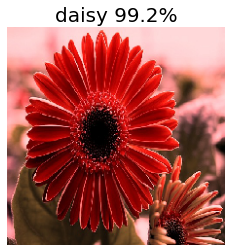

In [ ]:
#predict the result
cnn_feature = model_pretrained.predict(img_data, verbose=0)
# decode the results into a list of tuples (class, description, probability)
label = decode_predictions(cnn_feature)
label = label[0][0]
      
plt.imshow(img)
stringprint ="%.1f" % round(label[2]*100,1)
plt.title(label[1] + " " + str(stringprint) + "%", fontsize=20)
plt.axis('off')
plt.show()

In [ ]:
# decode the results into a list of tuples (class, description, probability)
# (one such list for each sample in the batch)
print('Predicted:', decode_predictions(cnn_feature, top=3)[0])

Predicted: [('n11939491', 'daisy', 0.9924114), ('n02319095', 'sea_urchin', 0.0018165705), ('n04525038', 'velvet', 0.0015322213)]


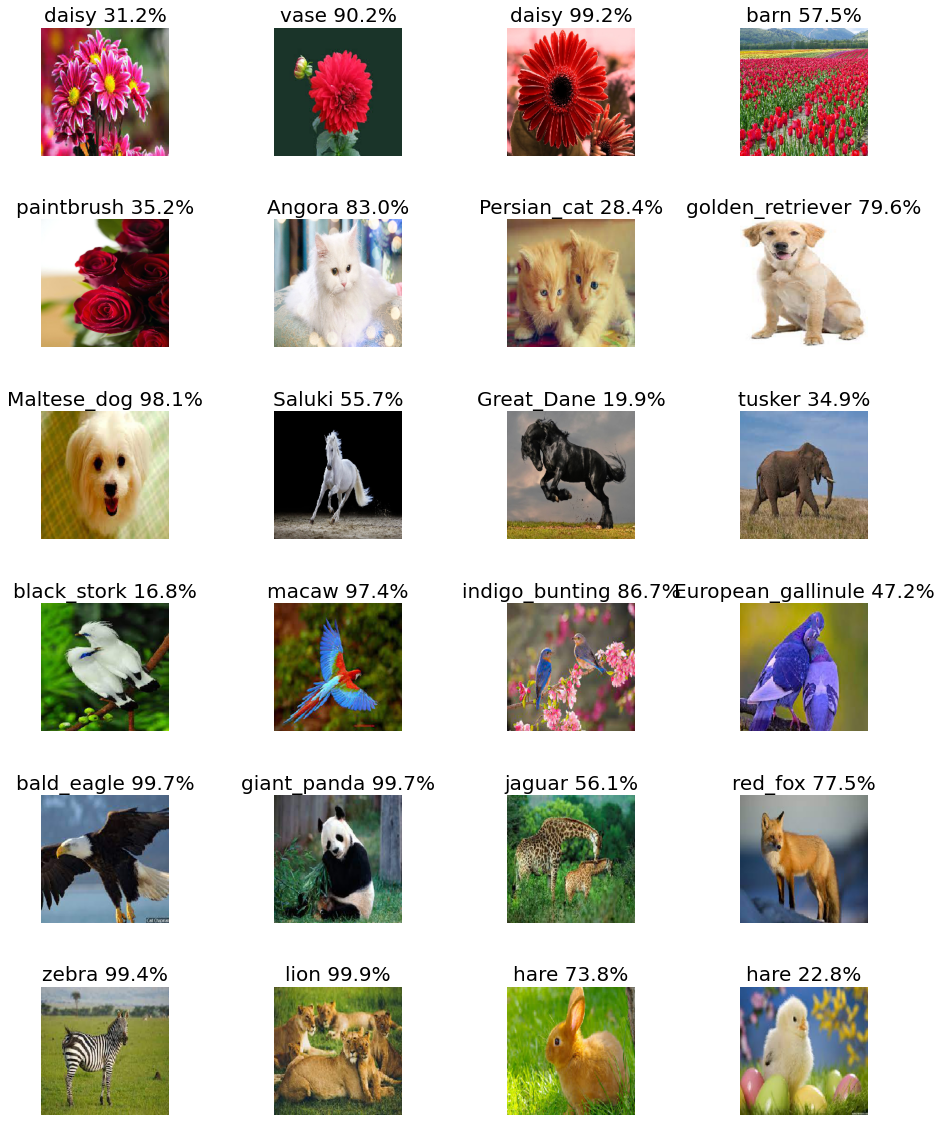

In [ ]:
# Insert correct path of your image folder below
folder_path = '/content/drive/My Drive/ImagesData/'
images = os.listdir(folder_path)
fig = plt.figure(figsize=(16,20))
i=0
rows=6
columns=4

for image1 in images:
   i+=1
   fimg = image.load_img(folder_path+image1, target_size=(img_width, img_height)) 
   fimg_data = image.img_to_array(fimg)
   fimg_data = np.expand_dims (fimg_data, axis=0)
   fimg_data = preprocess_input(fimg_data)
   cnn_feature = model_pretrained.predict(fimg_data, verbose=0)
   label = decode_predictions (cnn_feature)
   label = label[0][0]

   fig.add_subplot(rows,columns,i)
   fig.subplots_adjust(hspace=.5)

   plt.imshow(fimg)
   stringprint ="%.1f" % round(label[2]*100,1)
   plt.title(label[1] + " " + str(stringprint) + "%", fontsize=20)
   plt.axis('off')

plt.show()

#**Q1. The Fast Gradient Sign Method Attack**

The first step is to create perturbations which will be used to distort the original image resulting in an adversarial image. As mentioned, for this task, the gradients are taken with respect to the image.

In [ ]:
loss_object = tf.keras.losses.CategoricalCrossentropy()

def create_adversarial_pattern(input_image, input_label):
  with tf.GradientTape() as tape:
    tape.watch(input_image)
    prediction = model_pretrained(input_image)
    loss = loss_object(input_label, prediction)

  # Get the gradients of the loss w.r.t to the input image.
  gradient = tape.gradient(loss, input_image)
  # Get the sign of the gradients to create the perturbation
  signed_grad = tf.sign(gradient)
  return signed_grad

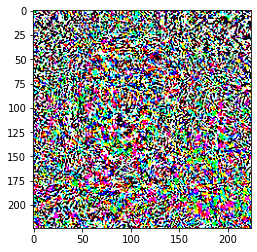

In [ ]:
# Get the input label of the image.

input_image_index = 985
label = tf.one_hot(input_image_index, cnn_feature.shape[-1])
label = tf.reshape(label, (1, cnn_feature.shape[-1]))

perturbations = create_adversarial_pattern(tf.convert_to_tensor(img_data), label)
plt.imshow(perturbations[0] * 0.5 + 0.5);  # To change [-1, 1] to [0,1]

In [ ]:
def display_images(image, description):
  cnn_pfeature = model_pretrained.predict(image, verbose=0)
  label = decode_predictions (cnn_pfeature, top=1)[0][0]
  
  confidence ="%.2f" % round(label[2]*100,1)
  plt.figure()
  plt.imshow(image[0]*0.5+0.5)
  
  plt.title('{} \n {} : {}% Confidence'.format(description,
                                                   label[1], str(confidence)))
  plt.show()

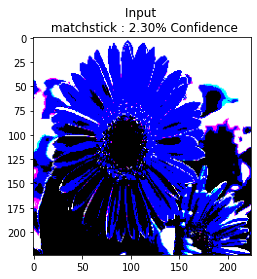

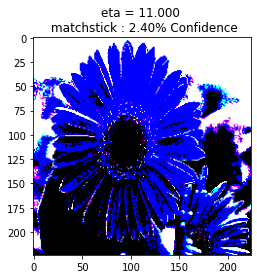

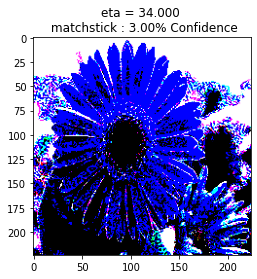

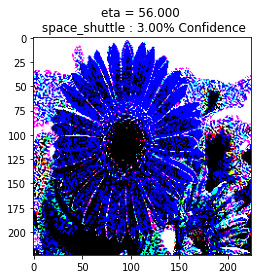

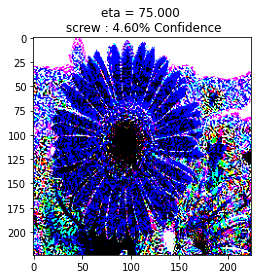

In [ ]:
eta = [0, 11, 34, 56, 75]
descriptions = [('eta = {:0.3f}'.format(eps) if eps else 'Input')
                for eps in eta]

for i, eps in enumerate(eta):
  adv_x = tf.convert_to_tensor(img_data) + eps*perturbations
  adv_x = tf.clip_by_value(adv_x, -1, 1)
  display_images(adv_x, descriptions[i])

In [ ]:
cnn_pmodel = model_pretrained.predict(adv_x, verbose=0)

In [ ]:
print('Predicted:', decode_predictions(cnn_pmodel, top=5)[0])

Predicted: [('n04153751', 'screw', 0.046335917), ('n04266014', 'space_shuttle', 0.025613721), ('n03729826', 'matchstick', 0.024186399), ('n04286575', 'spotlight', 0.02377894), ('n02783161', 'ballpoint', 0.022859676)]


#**Q2. Iterative Fast Gradient Sign Method Attack** 
PGD attack - Projected Gradient Descent Attack

In [8]:
pip install foolbox

     |████████████████████████████████| 1.7 MB 20.5 MB/s 
     |████████████████████████████████| 181 kB 44.0 MB/s 
     |████████████████████████████████| 63 kB 1.6 MB/s 
     |████████████████████████████████| 63 kB 1.6 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [9]:
from foolbox.models import TensorFlowModel
fooled_model = TensorFlowModel(model_pretrained, bounds=(-255, 255))

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


In [10]:
from foolbox.criteria import TargetedMisclassification

orig_class = 985
target_class = 34
target_label = tf.convert_to_tensor([target_class])

criterion = TargetedMisclassification(target_label)

In [11]:
from foolbox.attacks import PGD
eps = 57
attack_pgd = PGD()
x_adv_pgd = attack_pgd.run(fooled_model, tf.convert_to_tensor(img_data), criterion, epsilon=eps)

In [12]:
def display_pgd_images(image, eps):
  cnn_pfeature = model_pretrained.predict(image, verbose=0)
  label = decode_predictions (cnn_pfeature, top=1)[0][0]
  
  confidence ="%.2f" % round(label[2]*100,1)
  plt.figure()
  plt.imshow(image[0])
  
  plt.title('eta = {} \n {} : {}% Confidence'.format(eps,
                                                   label[1], str(confidence)))
  plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


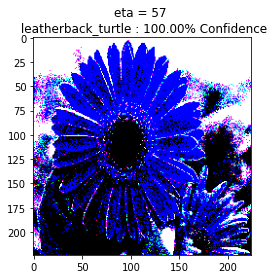

In [ ]:
display_pgd_images(x_adv_pgd, eps)

In [ ]:
model_pgd = model_pretrained.predict(x_adv_pgd, verbose=0)
print('Predicted:', decode_predictions(model_pgd, top=4)[0])

Predicted: [('n01665541', 'leatherback_turtle', 0.9998816), ('n03598930', 'jigsaw_puzzle', 5.724469e-06), ('n03724870', 'mask', 4.8977845e-06), ('n02672831', 'accordion', 4.762599e-06)]


49152/35363 [=========================================] - 0s 0us/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 1152x1440 with 0 Axes>

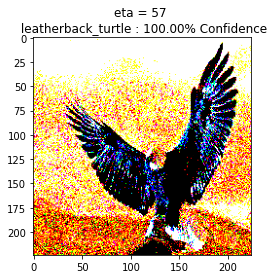

Predicted: [('n01665541', 'leatherback_turtle', 0.99997747), ('n04209239', 'shower_curtain', 2.0044579e-06), ('n02071294', 'killer_whale', 9.71508e-07), ('n04548362', 'wallet', 8.0739954e-07)]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


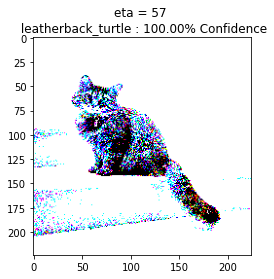

Predicted: [('n01665541', 'leatherback_turtle', 1.0), ('n01664065', 'loggerhead', 2.4971579e-08), ('n01667778', 'terrapin', 1.4726587e-08), ('n02317335', 'starfish', 6.6005743e-09)]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


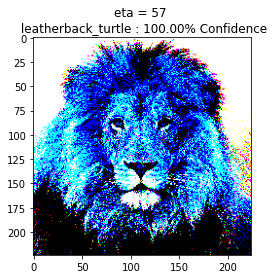

Predicted: [('n01665541', 'leatherback_turtle', 1.0), ('n04208210', 'shovel', 6.275246e-11), ('n01664065', 'loggerhead', 6.163928e-11), ('n03388043', 'fountain', 4.2433806e-11)]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


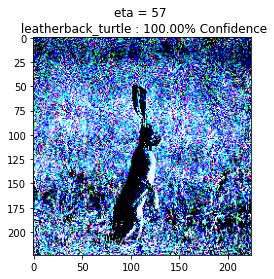

Predicted: [('n01665541', 'leatherback_turtle', 1.0), ('n01664065', 'loggerhead', 5.910014e-10), ('n01667114', 'mud_turtle', 8.4303155e-11), ('n04208210', 'shovel', 2.611032e-11)]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


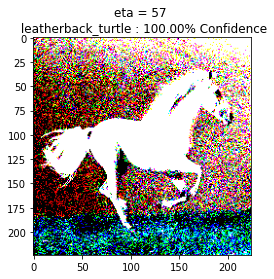

Predicted: [('n01665541', 'leatherback_turtle', 1.0), ('n01664065', 'loggerhead', 7.268121e-11), ('n01667778', 'terrapin', 1.6921456e-11), ('n01667114', 'mud_turtle', 5.025469e-12)]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


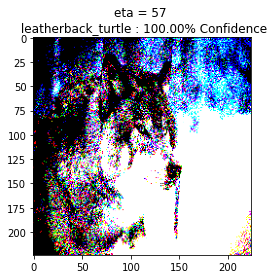

Predicted: [('n01665541', 'leatherback_turtle', 1.0), ('n01498041', 'stingray', 3.6369588e-10), ('n01664065', 'loggerhead', 2.469579e-10), ('n01688243', 'frilled_lizard', 1.4794029e-10)]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


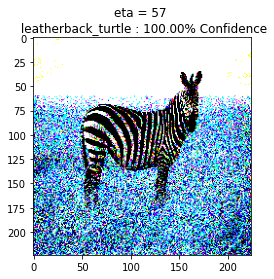

Predicted: [('n01665541', 'leatherback_turtle', 1.0), ('n01664065', 'loggerhead', 1.0172612e-09), ('n01667778', 'terrapin', 2.699492e-10), ('n02317335', 'starfish', 2.5159058e-10)]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


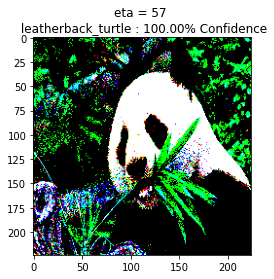

Predicted: [('n01665541', 'leatherback_turtle', 0.9997603), ('n04485082', 'tripod', 1.1299263e-05), ('n04127249', 'safety_pin', 1.12647895e-05), ('n03388043', 'fountain', 9.402807e-06)]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


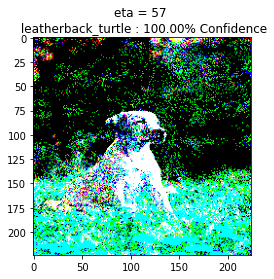

Predicted: [('n01665541', 'leatherback_turtle', 1.0), ('n03995372', 'power_drill', 3.7751222e-10), ('n01664065', 'loggerhead', 2.903112e-10), ('n01667778', 'terrapin', 2.620998e-10)]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


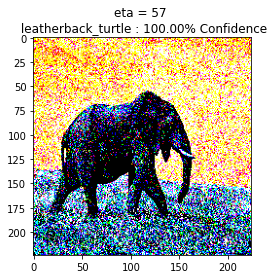

Predicted: [('n01665541', 'leatherback_turtle', 0.99989927), ('n01695060', 'Komodo_dragon', 3.815896e-06), ('n03223299', 'doormat', 3.4143998e-06), ('n01734418', 'king_snake', 2.9714965e-06)]


In [13]:
# Insert correct path of your image folder below
from foolbox.attacks import PGD
folder_path = '/content/drive/My Drive/ImagesData1/'
images = os.listdir(folder_path)
fig = plt.figure(figsize=(16,20))
i=0
rows=5
columns=2

for image1 in images:
   i+=1
   fimg = image.load_img(folder_path+image1, target_size=(img_width, img_height)) 
   fimg_data = image.img_to_array(fimg)
   fimg_data = np.expand_dims (fimg_data, axis=0)
   fimg_data = preprocess_input(fimg_data)
   cnn_feature = model_pretrained.predict(fimg_data, verbose=0)
   label = decode_predictions (cnn_feature)
   label = label[0][0]

   eps = 57
   attack_pgd = PGD()
   x_adv_pgd = attack_pgd.run(fooled_model, tf.convert_to_tensor(fimg_data), criterion, epsilon=eps)   

   display_pgd_images(x_adv_pgd, eps)

   model_pgd = model_pretrained.predict(x_adv_pgd, verbose=0)
   print('Predicted:', decode_predictions(model_pgd, top=4)[0])

#**Q3. Carlini Wagner Attack**

In [ ]:
!pip install adversarial-robustness-toolbox

     |████████████████████████████████| 1.3 MB 12.5 MB/s 
     |████████████████████████████████| 3.3 MB 52.6 MB/s 
     |████████████████████████████████| 34.5 MB 20 kB/s 
  Attempting uninstall: llvmlite
    Found existing installation: llvmlite 0.34.0
    Uninstalling llvmlite-0.34.0:
      Successfully uninstalled llvmlite-0.34.0
  Attempting uninstall: numba
    Found existing installation: numba 0.51.2
    Uninstalling numba-0.51.2:
      Successfully uninstalled numba-0.51.2


In [ ]:
from art.estimators.classification import TensorFlowV2Classifier
from art.attacks.evasion import CarliniL2Method

In [ ]:
import warnings
warnings.filterwarnings('ignore') 

In [ ]:
classifier = TensorFlowV2Classifier(model=model_pretrained, nb_classes=1000, input_shape=(img_width, img_height), loss_object=loss_object,clip_values=(-1, 1), channels_first=False)

In [ ]:
from art.attacks.evasion.carlini import CarliniL2Method
attack_cw = CarliniL2Method(classifier=classifier,max_iter=10,learning_rate=0.05)

In [ ]:
x_test_adv = attack_cw.generate(img_data1);

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
predictions = classifier.predict(x_test_adv)
print(np.argmax(predictions, axis=1))


[328]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


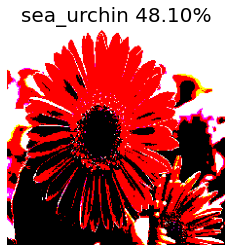

In [ ]:
label = decode_predictions(classifier.predict(x_test_adv))
label = label[0][0]

predictions = classifier.predict(x_test_adv)

confidence ="%.2f" % round(label[2]*100,1)

plt.imshow(x_test_adv[0])
plt.title(label[1] + " " + format(confidence) + "%", fontsize=20)
plt.axis('off')
plt.show()

In [ ]:
print('Predicted:', decode_predictions(predictions, top=3)[0])

Predicted: [('n02319095', 'sea_urchin', 0.48072088), ('n11939491', 'daisy', 0.19630083), ('n07730033', 'cardoon', 0.061766442)]
